# Load CholecSeg8k from Local Directory

Minimal example to load and display an example from the local CholecSeg8k dataset.

In [1]:
import sys
sys.path.insert(0, '/shared_data0/weiqiuy/llm_cholec_organ/src')

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from endopoint.datasets import build_dataset

In [10]:
# Load the local dataset
dataset = build_dataset(
    "cholecseg8k_local", 
    data_dir="/shared_data0/weiqiuy/datasets/cholecseg8k"
)

print(f"Dataset: {dataset.dataset_tag}")
print(f"Train examples: {dataset.total('train')}")
print(f"Validation examples: {dataset.total('validation')}")
print(f"Test examples: {dataset.total('test')}")

Dataset: cholecseg8k_local
Train examples: 3288
Validation examples: 411
Test examples: 412


In [ ]:
# Check the video-based splits
video_splits = dataset.get_video_splits()

print("Video-based splits:")
print("=" * 50)
for split_name, video_ids in video_splits.items():
    print(f"\n{split_name.upper()} split ({len(video_ids)} videos):")
    print(f"  Videos: {', '.join(sorted(video_ids))}")
    
    # Count frames per video in this split
    frame_counts = {}
    for idx in range(dataset.total(split_name)):
        example = dataset.get_example(split_name, idx)
        vid = example['video_id']
        frame_counts[vid] = frame_counts.get(vid, 0) + 1
    
    for vid in sorted(video_ids):
        if vid in frame_counts:
            print(f"    {vid}: {frame_counts[vid]} frames")

print("\n" + "=" * 50)
print("Verification: No video appears in multiple splits")
all_videos = set()
for split_name, video_ids in video_splits.items():
    overlap = all_videos.intersection(set(video_ids))
    if overlap:
        print(f"  WARNING: {overlap} appears in multiple splits!")
    all_videos.update(video_ids)
print("  ✓ All videos are properly separated by split")

In [3]:
# Load a single example
example = dataset.get_example("train", 0)

image = example['image']  # PIL Image
color_mask = example['color_mask']  # PIL Image with color-coded segmentation

print(f"Frame ID: {example['frame_id']}")
print(f"Video ID: {example['video_id']}")
print(f"Image size: {image.size}")

Frame ID: video01_video01_15099_15138
Video ID: video01
Image size: (854, 480)


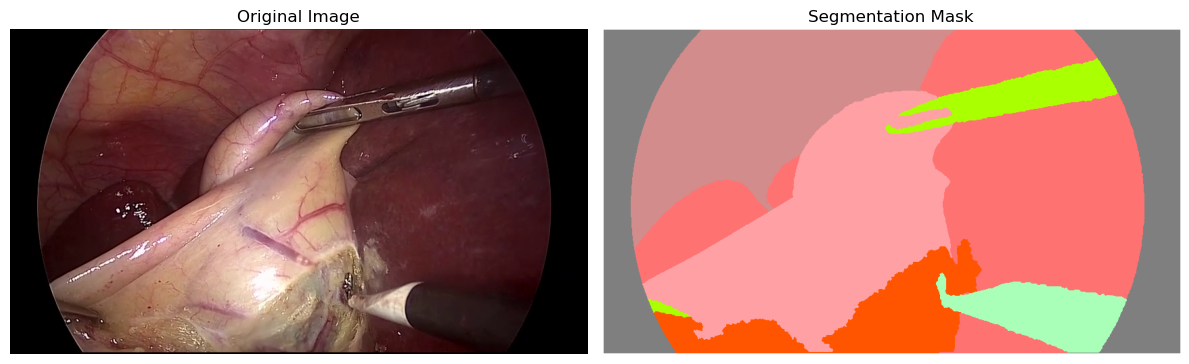

In [4]:
# Display the image and mask
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(image)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(color_mask)
axes[1].set_title('Segmentation Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Convert to tensors and check organ presence
img_tensor, label_tensor = dataset.example_to_tensors(example)
presence = dataset.labels_to_presence_vector(label_tensor)

print("Organs present in this image:")
for i, p in enumerate(presence):
    if p == 1:
        organ_name = dataset.id2label[i + 1]
        point = dataset.sample_point_in_mask(label_tensor, i + 1, strategy="centroid")
        print(f"  - {organ_name} at point {point}")

Organs present in this image:
  - Abdominal Wall at point (233, 112)
  - Liver at point (569, 232)
  - Grasper at point (591, 112)
  - Connective Tissue at point (377, 425)
  - L-hook Electrocautery at point (650, 419)
  - Gallbladder at point (329, 295)


In [6]:
# Get bounding boxes for all organs
bboxes = dataset.get_bounding_boxes(label_tensor)

print("Bounding boxes by organ:")
for class_id, boxes in bboxes.items():
    organ_name = dataset.id2label[class_id]
    print(f"\n{organ_name}: {len(boxes)} region(s)")
    for i, bbox in enumerate(boxes):
        x_min, y_min, x_max, y_max = bbox
        width = x_max - x_min + 1
        height = y_max - y_min + 1
        print(f"  Region {i+1}: ({x_min}, {y_min}) to ({x_max}, {y_max}) - Size: {width}x{height}")

Bounding boxes by organ:

Abdominal Wall: 1 region(s)
  Region 1: (41, 1) to (520, 324) - Size: 480x324

Liver: 6 region(s)
  Region 1: (468, 1) to (729, 101) - Size: 262x101
  Region 2: (487, 94) to (799, 397) - Size: 313x304
  Region 3: (241, 187) to (290, 264) - Size: 50x78
  Region 4: (46, 223) to (243, 375) - Size: 198x153
  Region 5: (530, 389) to (540, 392) - Size: 11x4
  Region 6: (496, 419) to (685, 478) - Size: 190x60

Grasper: 2 region(s)
  Region 1: (417, 43) to (759, 154) - Size: 343x112
  Region 2: (67, 398) to (128, 425) - Size: 62x28

Connective Tissue: 1 region(s)
  Region 1: (75, 310) to (559, 478) - Size: 485x169

L-hook Electrocautery: 1 region(s)
  Region 1: (492, 360) to (773, 477) - Size: 282x118

Gallbladder: 1 region(s)
  Region 1: (58, 91) to (516, 476) - Size: 459x386


In [7]:
# Get bounding boxes with labels (more convenient format)
bbox_list = dataset.get_bounding_boxes_with_labels(label_tensor)

print(f"Total bounding boxes: {len(bbox_list)}")
for box_info in bbox_list[:5]:  # Show first 5
    print(f"  {box_info['class_name']}: bbox={box_info['bbox']}, area={box_info['area']} pixels")

Total bounding boxes: 12
  Abdominal Wall: bbox=(41, 1, 520, 324), area=74803 pixels
  Liver: bbox=(468, 1, 729, 101), area=16765 pixels
  Liver: bbox=(487, 94, 799, 397), area=73505 pixels
  Liver: bbox=(241, 187, 290, 264), area=2013 pixels
  Liver: bbox=(46, 223, 243, 375), area=14429 pixels


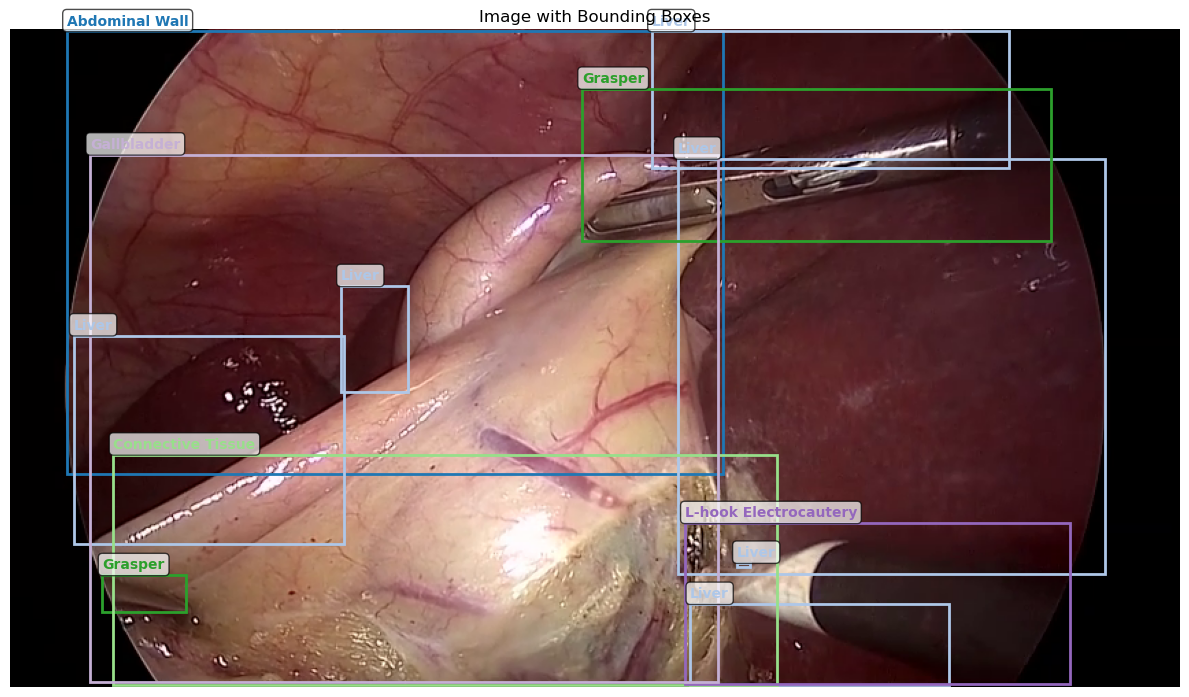

In [8]:
# Visualize bounding boxes on the image
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(image)

# Define colors for each organ class
colors = plt.cm.tab20(range(20))

# Draw bounding boxes
for box_info in bbox_list:
    x_min, y_min, x_max, y_max = box_info['bbox']
    width = x_max - x_min
    height = y_max - y_min
    
    # Get color for this class
    color_idx = (box_info['class_id'] - 1) % 20
    color = colors[color_idx]
    
    # Create rectangle patch
    rect = patches.Rectangle((x_min, y_min), width, height,
                            linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    
    # Add label
    ax.text(x_min, y_min - 5, box_info['class_name'], 
           color=color, fontsize=10, weight='bold',
           bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

ax.set_title('Image with Bounding Boxes')
ax.axis('off')
plt.tight_layout()
plt.show()

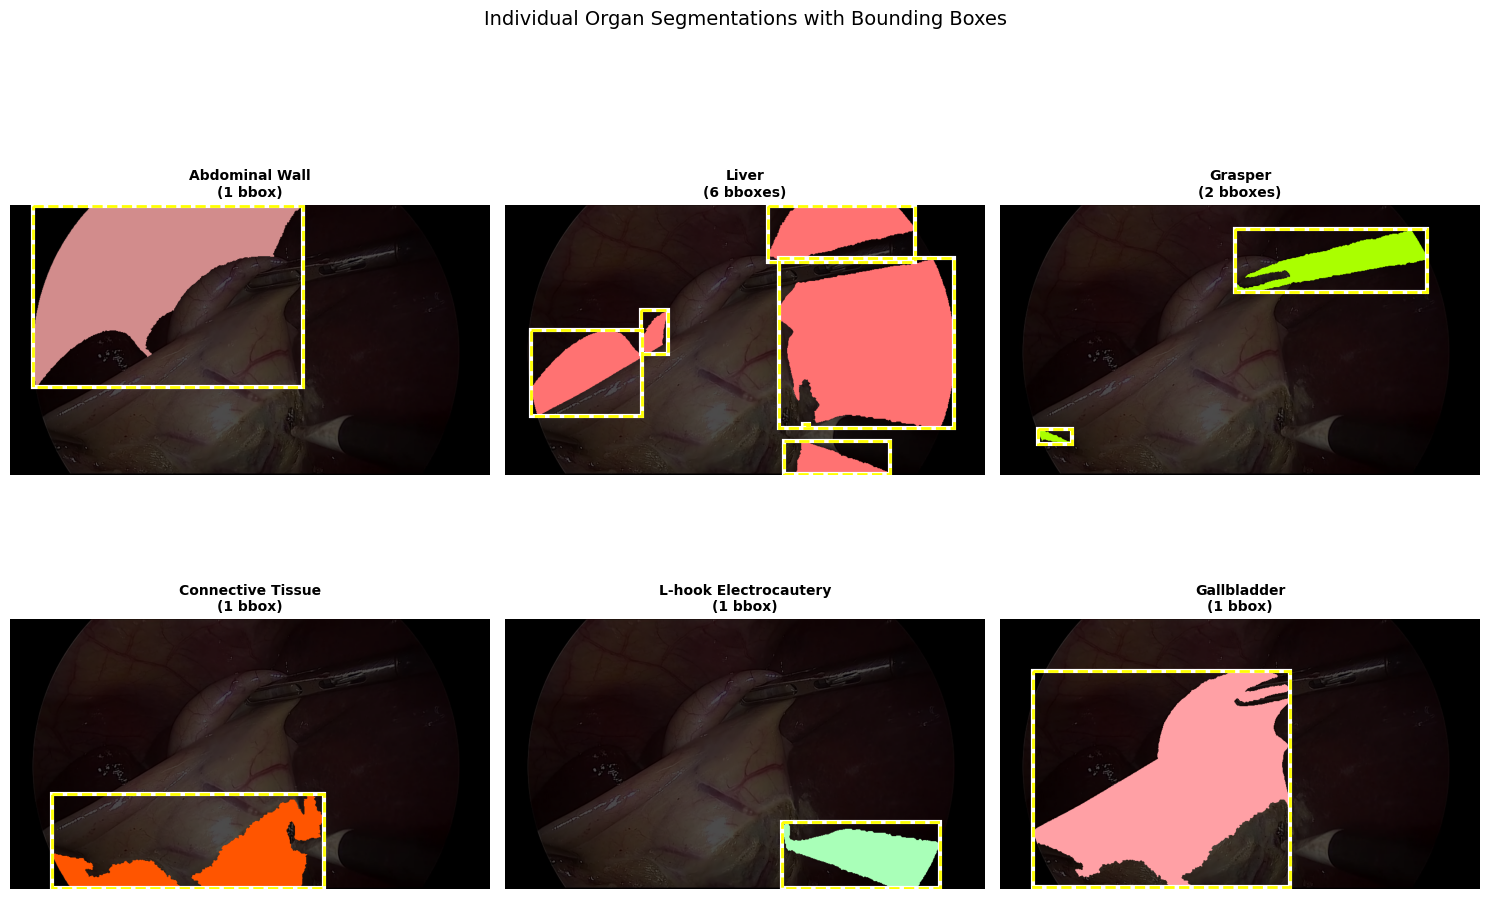

In [9]:
# Visualize each organ's segmentation with its bounding boxes separately
import numpy as np
from collections import defaultdict

# Group bounding boxes by organ class
organ_bboxes = defaultdict(list)
for box_info in bbox_list:
    organ_bboxes[box_info['class_id']].append(box_info)

# Create subplots for each organ present
n_organs = len(organ_bboxes)
n_cols = 3
n_rows = (n_organs + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

# Flatten axes for easier iteration
axes_flat = axes.flatten()

# Hide unused subplots
for ax in axes_flat[n_organs:]:
    ax.axis('off')

# Process each organ
label_array = np.array(label_tensor)
color_mask_array = np.array(color_mask)

for idx, (class_id, bboxes) in enumerate(organ_bboxes.items()):
    ax = axes_flat[idx]
    
    # Create a background (dimmed original image)
    background = np.array(image) * 0.3  # Dim the original image
    background = background.astype(np.uint8)
    
    # Create mask for this organ
    organ_mask = (label_array == class_id)
    
    # Create visualization with organ highlighted
    vis_image = background.copy()
    
    # Get the organ's color from the color mask
    if organ_mask.any():
        # Apply the segmentation color to the organ regions
        vis_image[organ_mask] = color_mask_array[organ_mask]
    
    # Display the image
    ax.imshow(vis_image)
    
    # Draw all bounding boxes for this organ
    for box_info in bboxes:
        x_min, y_min, x_max, y_max = box_info['bbox']
        width = x_max - x_min
        height = y_max - y_min
        
        # Draw bounding box with white border
        rect = patches.Rectangle((x_min, y_min), width, height,
                                linewidth=3, edgecolor='white', facecolor='none')
        ax.add_patch(rect)
        
        # Draw inner colored rectangle for contrast
        rect_inner = patches.Rectangle((x_min, y_min), width, height,
                                      linewidth=2, edgecolor='yellow', facecolor='none', linestyle='--')
        ax.add_patch(rect_inner)
    
    # Set title with organ name and bbox count
    organ_name = dataset.id2label[class_id]
    ax.set_title(f'{organ_name}\n({len(bboxes)} bbox{"es" if len(bboxes) > 1 else ""})', fontsize=10, weight='bold')
    ax.axis('off')

plt.suptitle('Individual Organ Segmentations with Bounding Boxes', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()